In [1]:
#package
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from WindPy import w

In [ ]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 主成分分析

In [ ]:
'''
stock:
沪深300 - 000300.SH
中证500 - 000905.SH
中证1000 - 000852.SH

跨境股票:
标普500 - SPX.GI

债券:
中债7-10年政策性金融债 - CBA08203.CS
中债1-3年国债 - 931552.CSI

商品或其他:
黄金(Au9999) - AU9999.SGE
大商所豆粕期货 - M.DCE
华夏中国交建REIT - 508018.SH #剔除
'''
investment_pool = ['000300.SH','000905.SH','000852.SH','SPX.GI','CBA08203.CS','931552.CSI','AU9999.SGE','M.DCE']
# str = ','.join(investment_pool)
# history_data=w.wsd(str,
#                    "close", 
#                    "2012-01-01", 
#                    "2025-9-30",  
#                    'Period=M',
#                    usedf=True) 
price_data = history_data[1]
price_data.to_csv('./price_data/micro_research_price_data.csv')
price_data = pd.read_csv('./price_data/micro_research_price_data.csv',index_col=0,parse_dates=True)
price_data

,000300.SH,000905.SH,000852.SH,SPX.GI,CBA08203.CS,931552.CSI,AU9999.SGE,M.DCE
2012-01-31,2464.2600,3294.4940,3406.6750,1312.41,100.5874,115.4840,354.16,2943.0
2012-02-29,2634.1430,3696.1440,3858.5420,1365.68,98.9514,115.4220,361.96,3138.0
2012-03-30,2454.8990,3416.8560,3560.4850,1408.47,98.7931,116.0090,339.04,3244.0
2012-04-27,2626.1570,3664.6380,3837.8780,1397.91,97.7315,116.2120,336.09,3345.0
2012-05-31,2632.0420,3753.5930,3898.5910,1310.33,100.0414,117.5180,321.75,3145.0
...,...,...,...,...,...,...,...,...
2025-05-30,3840.2323,5671.0723,6026.5603,5911.69,123.7543,173.6745,768.79,2968.0
2025-06-30,3936.0791,5915.3876,6356.1813,6204.95,124.0135,174.1445,764.43,2961.0
2025-07-31,4075.5912,6226.3432,6661.1862,6339.39,123.2563,174.2714,767.36,3000.0
2025-08-29,4496.7591,7043.9416,7438.6767,6460.26,122.3327,174.5363,781.71,3055.0


In [40]:
ret_data = price_data.pct_change().iloc[1:]
cum12_ret_data= ret_data.rolling(window=12).apply(lambda x: (1+x).prod()-1).iloc[11:]


In [47]:
cum12_ret_data_standardize = (cum12_ret_data - cum12_ret_data.mean()) / cum12_ret_data.std()

In [41]:
from PCAanalysis import PCAAnalyzer
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

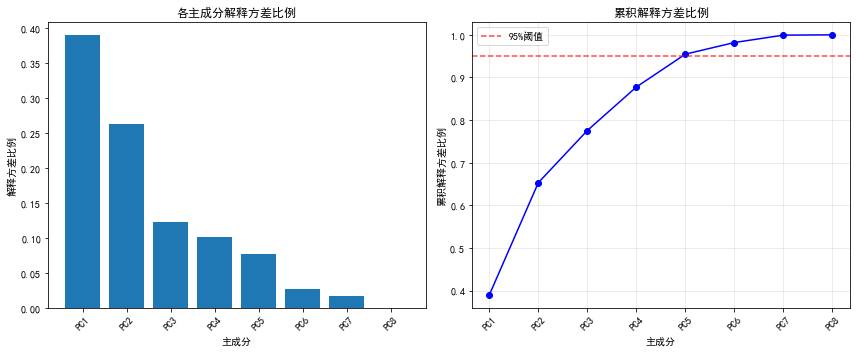

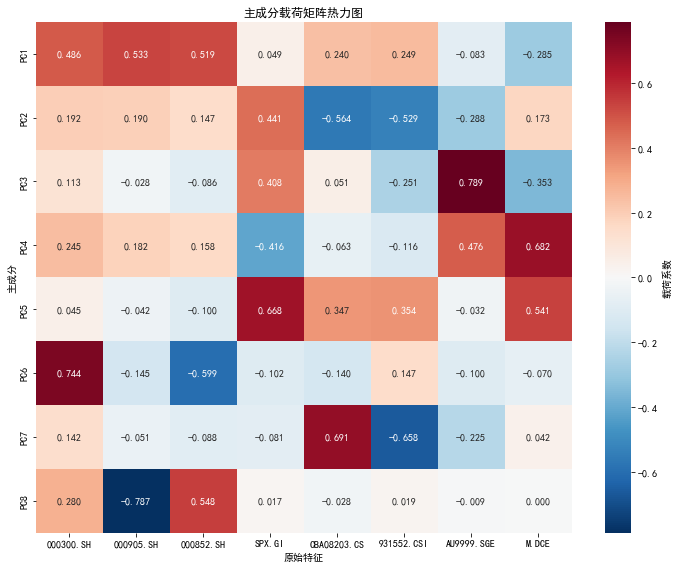

In [48]:
pca_analyzer = PCAAnalyzer(standardize=True)
pca_analyzer.fit(cum12_ret_data_standardize)

# 获取分析结果
summary = pca_analyzer.get_summary_statistics()
components = pca_analyzer.get_components_matrix()

# 可视化
pca_analyzer.plot_explained_variance()
pca_analyzer.plot_components_heatmap()


In [56]:
cum12_ret_data_standardize

,000300.SH,000905.SH,000852.SH,SPX.GI,CBA08203.CS,931552.CSI,AU9999.SGE,M.DCE
2013-01-31,0.095575,-0.074738,-0.056094,0.100190,-0.739297,-0.395485,-0.737503,1.259328
2013-02-28,-0.199649,-0.360254,-0.308978,-0.160760,-0.272564,-0.181555,-1.076188,0.448498
2013-03-29,-0.193807,-0.243540,-0.137795,-0.120428,-0.192302,-0.354597,-0.776671,-0.018629
2013-04-26,-0.524270,-0.564477,-0.448304,0.110922,0.223412,-0.211270,-1.154337,-0.324753
2013-05-31,-0.295917,-0.192004,-0.018258,0.930202,-0.135185,-0.988905,-1.198586,0.145770
...,...,...,...,...,...,...,...,...
2025-05-30,0.026617,-0.031570,0.125912,-0.071634,0.499106,-0.683884,1.915361,-0.968706
2025-06-30,0.278310,0.427019,0.676859,0.058641,0.388856,-0.778879,1.924244,-0.784231
2025-07-31,0.462165,0.703436,0.881517,0.152284,0.076272,-1.019565,1.755633,-0.184018
2025-08-29,1.126491,1.574941,1.660392,0.118214,-0.008901,-0.994485,1.760719,0.071554


In [63]:
pca_ret = pd.DataFrame(pca_analyzer.transform(),index=cum12_ret_data_standardize.index).iloc[:,:-2]
pca_ret

,0,1,2,3,4,5
2013-01-31,-0.593737,1.099857,-0.908909,0.561511,0.388713,0.136659
2013-02-28,-0.608743,0.414844,-1.030376,-0.265159,0.047310,0.193265
2013-03-29,-0.367551,0.360372,-0.581007,-0.393536,-0.243879,0.039579
2013-04-26,-0.595816,0.036286,-0.693617,-1.111868,-0.017254,0.024577
2013-05-31,-0.433272,1.287743,-0.404047,-0.847184,0.339065,-0.294233
...,...,...,...,...,...,...
2025-05-30,0.125161,-0.653880,2.020838,0.350361,-0.713387,-0.339200
2025-06-30,0.682576,-0.236384,2.002269,0.677588,-0.661612,-0.574556
2025-07-31,0.737979,0.381062,1.734745,1.144672,-0.486198,-0.626822
2025-08-29,1.844116,0.853532,1.607353,1.784779,-0.476309,-0.724540


# 宏观数据获取

In [ ]:
'''
获取宏观数据
经济:  工业增加值当月同比的滚动 3 个月平均 # M0061675-Wind一致预期 # M0000545-规模以上工业企业增加值 *
流动性: 10 年期国债到期收益率  # S0059749-中债10年期国债到期收益率 *  # M1001654-中国10年期国债到期收益率
通胀: CPI同比  # M0061676-Wind一致预期CPI同比 # M0000612-CPI当月同比 * 
通胀: PPI同比 # M0061677-Wind一致预期PPI同比 # M0001227-PPI当月同比 * 
信用: 累计12个月新增社融同比增速 # M5206731 社融:新增人民币贷款 
                            # M5206732 社融:新增外币贷款 
                            # M5206733 社融:新增委托贷款 
                            # M5206734 社融:新增信托贷款
                            # M5206735 社融:新增未贴现银行汇票
'''


'\n获取宏观数据\n'

In [ ]:
# 1.关于GDP
# macro_data = w.edb("M0061675,M0000545,S0059749,M1001654,M0061676,M0000612,M0061677,M0001227,M5206731,M5206732,M5206733,M5206734,M5206735",
#                    "2009-01-01",
#                    "2025-10-27",
#                    "Fill=Previous",
#                    'Period=M',
#                    usedf=True)
# macro_data = macro_data[1]
# macro_data.to_csv("./price_data/macro_social_data.csv")
macro_data = pd.read_csv("./price_data/macro_social_data.csv", index_col=0,parse_dates=True)
macro_data = macro_data.resample('M').last().dropna().loc[:'2025-09-30']
# macro_data.resample("Y").count()

In [107]:
macro_data['新增社融'] = macro_data[['M5206731', 'M5206732', 'M5206733', 'M5206734', 'M5206735']].sum(axis=1)
macro_data['累计12个月新增社融'] = macro_data['新增社融'].rolling(12).sum()
macro_data['累计12个月新增社融同比增速'] = macro_data['累计12个月新增社融'].pct_change(12)

In [ ]:
macro_data_cal = 


,新增社融,累计12个月新增社融,累计12个月新增社融同比增速
2009-01-31,13279.0,NaN,NaN
2009-02-28,10507.0,NaN,NaN
2009-03-31,20453.0,NaN,NaN
2009-04-30,3563.0,NaN,NaN
2009-05-31,13669.0,NaN,NaN
2009-06-30,19434.0,NaN,NaN
2009-07-31,5812.0,NaN,NaN
2009-08-31,6574.0,NaN,NaN
2009-09-30,9679.0,NaN,NaN
2009-10-31,4785.0,NaN,NaN
